**二维阻尼振荡器**

作为第一个说明性示例，我们考虑具有三次动态的二维阻尼谐振子，即：

$$
\begin{array}{l}
\dot{x} = -0.1\ x^3 + 2.0\ y^3,\\
\dot{y} = -2.0\ x^3 - 0.1\ y^3.
\end{array}
$$

我们使用初始条件 $[x_0\ y_0]^T = [2\ 0]^T$，并从 $t = 0$ 到 $t = 25$ 收集数据，时间步长为 $\Delta t = 0.01$。数据绘制在下图中。我们使用一个具有一层隐藏层和256个神经元的神经网络来表示非线性动力学。对于多步方案，我们采用 $M=1$ 步长的 Adams-Moulton 方法（即梯形规则）。在训练神经网络之后，我们使用与上述相同的初始条件求解识别出的系统。下图定性地评估了识别正确非线性动力学的准确性。具体来说，通过比较系统的精确轨迹和预测轨迹以及所得的相图，我们可以看到算法能够正确捕捉到系统的动态演变。

> _谐振子：_ 左侧面板显示了具有三次动态的二维阻尼谐振子的轨迹，而右侧面板绘制了相应的相图。彩色实线表示精确的动力学，虚线表示学习到的动力学。识别出的系统能够正确捕捉动力学形式，并准确再现相图。

It: 0, Loss: 8.1320255994796753e-03
It: 500, Loss: 1.5806481314939447e-05
It: 1000, Loss: 3.2896061838982860e-06
It: 1500, Loss: 1.0348828709538793e-06
It: 2000, Loss: 4.8560809773334768e-07
It: 2500, Loss: 3.0906832648724958e-07
It: 3000, Loss: 2.2823499534752045e-07
It: 3500, Loss: 2.4744582560742856e-07
It: 4000, Loss: 1.5204288672521216e-07
It: 4500, Loss: 1.3181582403376524e-07
Time: 10.7325


<function matplotlib.pyplot.show(close=None, block=None)>

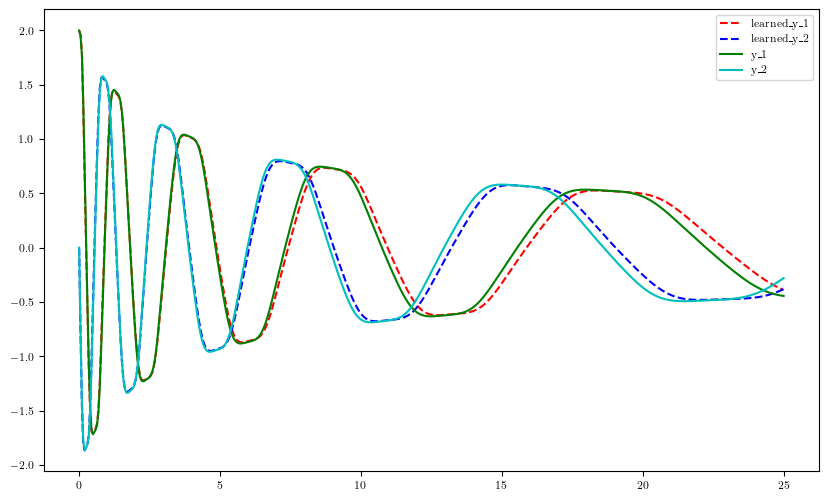

In [8]:
import numpy as np
from scipy.integrate import odeint
from Multistep_NN import Multistep_NN
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import timeit


start_time = timeit.default_timer()

# define solution
sol_fun_1 = lambda x:  (-0.1)* x[:,[0]]**3 + 2 * x[:,[1]]**3 
sol_fun_2 = lambda x:  (-2)* x[:,[0]]**3 + (-0.1) * x[:,[1]]**3 

torch.manual_seed(0)
if __name__ == "__main__": 
    
    # function that returns dx/dt
    def f(x,t): # x is 2 x 1
        A = np.array([[-.1,2], [-2,-.1]]) # 2 x 2
        f = np.matmul(A,x[:,None]**3) # 2 x 1
        return f.flatten()
    
    # time points
    n_steps = 512
    # t_star = np.arange(0,25,0.01)
    t_star = np.linspace(0, 25, num=n_steps)
    # initial condition
    x0 = np.array([2,0])
    X_star = odeint(f, x0, t_star)


    # test_steps = 1000
    # # test_np = np.random.uniform(0, 2, test_steps)
    # test_np = np.linspace(0, 25, num=test_steps)
    # # y_test_np =torch.from_numpy(odeint(f,  x0, test_np))
    # y_test = odeint(f,  x0, test_np)
    # X_test = np.reshape(y_test, (1,y_test.shape[0],y_test.shape[1])).shape

    # y_test_np1 = y_test_np[:,0]
    # y_test_np2 = y_test_np[:,1]
    
    # f_test_1 =sol_fun_1(y_test_np)
    # f_test_2 =sol_fun_2(y_test_np)
    # f_test = torch.cat((f_test_1, f_test_2), dim=1).detach()
    # f_nn= model(y_test_np).detach()
    # Test_loss =  torch.mean((f_test - f_nn)**2)
    # print(f'Test_loss: {Test_loss.item():.3e}')

    
    noise = 0.00

    skip = 1
    dt = t_star[skip] - t_star[0]
    X_train = X_star[0::skip,:]
    X_train = X_train + noise*X_train.std(0)*np.random.randn(X_train.shape[0], X_train.shape[1])
    
    X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))
    layers = [2, 29, 2]
    
    M = 1
    scheme = 'AM'
    model = Multistep_NN(dt, X_train, layers, M, scheme)
    N_Iter = 5000
    model.train_model(N_Iter)

    elapsed = timeit.default_timer() - start_time
    print(f"Time: {elapsed:.4f}")


    def learned_f(x,t):
        f = model.predict_f(x[None,:])
        return f.flatten()
    
    learned_X_star = odeint(learned_f, x0, t_star)    

####### Plotting ################## 
plt.figure(figsize=(10, 6))
plt.plot(t_star, learned_X_star[:,0], label='learned_y_1',linestyle='--', color='r')
plt.plot(t_star, learned_X_star[:,1], label='learned_y_2',linestyle='--', color='b')
plt.plot(t_star, X_star[:,0], label='y_1', color='g')
plt.plot(t_star, X_star[:,1], label='y_2', color='c')
plt.legend()
plt.show
    

In [2]:
# X_train
y_test = odeint(f,  x0, test_np)
np.reshape(y_test, (1,y_test.shape[0],y_test.shape[1])).shape

NameError: name 'test_np' is not defined

In [ ]:
####### Plotting ################## 
fig, ax = newfig(1.0, 0.9)
ax.axis('off')

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.85, bottom=0.25, left=0.1, right=0.95, wspace=0.3)

ax = plt.subplot(gs0[:, 0:1])
ax.plot(t_star,X_star[:,0],'r',label='$x$')
ax.plot(t_star,X_star[:,1],'b',label='$y$')
ax.plot(t_star,learned_X_star[:,0],'k--',label='learned model')
ax.plot(t_star,learned_X_star[:,1],'k--')    
ax.set_xlabel('$t$')
ax.set_ylabel('$x, y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.9, -0.25), ncol=3, frameon=False)
ax.set_title('Trajectories', fontsize = 10)

ax = plt.subplot(gs0[:, 1:2])
ax.plot(X_star[:,0],X_star[:,1], 'm', label='$(x,y)$')
ax.plot(learned_X_star[:,0],learned_X_star[:,1],'k--')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.25), ncol=1, frameon=False)
ax.set_title('Phase Portrait', fontsize = 10)

savefig('./figures/Cubic2D')